# Предсказание рейтинга фильма по тексту отзыва

## Источник данных : http://ai.stanford.edu/~amaas/data/sentiment/
### _This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets.<br>This dataset contains movie reviews along with their associated binary sentiment polarity labels. It is intended to serve as a benchmark for sentiment classification._
### _The core dataset contains 50,000 reviews split evenly into 25k train and 25k test sets. The overall distribution of labels is balanced (25k pos and 25k neg)._

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Чтение данных из файлов - формирование набора данных

### Данные представлены в виде .txt файлов с именами вида [id]_[rating].txt, [id] - уникальный идентификатор отзыва, [rating] - рейтинг фильма по шкале от 1 до 10.

In [2]:
train_neg_path = './data/train/neg/'
train_pos_path = './data/train/pos/'
test_pos_path = './data/test/pos/'
test_neg_path = './data/test/neg/'

In [3]:
from pathlib import Path

In [4]:
def read_folder(folder_path):
    result_dict = {'id':[], 'score':[], 'review':[]}
    for path in list(Path(folder_path).glob('*.txt')):
        review_id, movie_score = tuple(path.stem.split('_'))                
        review_text = path.read_text(encoding='utf8')
        result_dict['id'].append(int(review_id))
        result_dict['score'].append(int(movie_score))
        result_dict['review'].append(review_text)
    return pd.DataFrame.from_dict(result_dict)

In [5]:
read_folder(test_pos_path)

,id,score,review
0,0,10,I went and saw this movie last night after bei...
1,10000,7,Actor turned director Bill Paxton follows up h...
2,10001,9,As a recreational golfer with some knowledge o...
3,10002,8,"I saw this film in a sneak preview, and it is ..."
4,10003,8,Bill Paxton has taken the true story of the 19...
...,...,...,...
12495,9998,8,I was extraordinarily impressed by this film. ...
12496,9999,10,"Although I'm not a golf fan, I attended a snea..."
12497,999,8,"From the start of ""The Edge Of Love"", the view..."
12498,99,10,"This movie, with all its complexity and subtle..."


In [6]:
train_neg_df = read_folder(train_neg_path)
train_pos_df = read_folder(train_pos_path)
test_neg_df = read_folder(test_neg_path)
test_pos_df = read_folder(test_pos_path)

___Распределение рейтинга фильмов тренировочного набора___

In [7]:
train_neg_df['is_positive'] = 0
train_pos_df['is_positive'] = 1
train_data = pd.concat([train_neg_df, train_pos_df], axis=0)
train_data.to_csv('imdb_reviews_train.csv', sep=';', encoding='utf8')

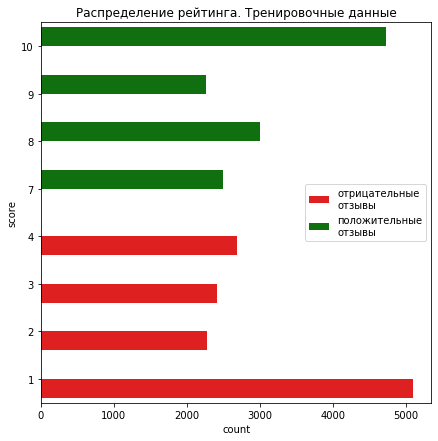

In [8]:
plt.figure(figsize=(7,7))
ax = sns.countplot(y='score', data=train_data, hue='is_positive', palette={0:'red', 1:'green'})
ax.invert_yaxis()
plt.title('Распределение рейтинга. Тренировочные данные');
plt.legend(['отрицательные\nотзывы', 'положительные\nотзывы'],loc='center right');

___Распределение рейтинга фильмов тестового набора___

In [9]:
test_neg_df['is_positive'] = 0
test_pos_df['is_positive'] = 1
test_data = pd.concat([test_neg_df, test_pos_df], axis=0)
test_data.to_csv('imdb_reviews_test.csv', sep=';', encoding='utf8')

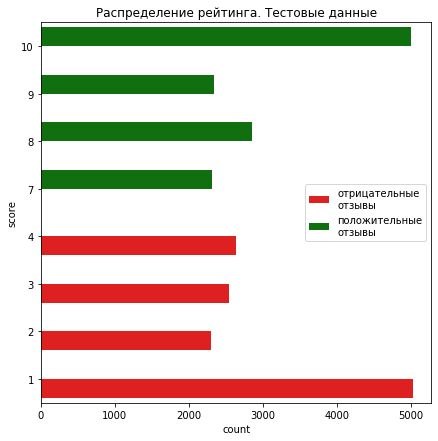

In [10]:
plt.figure(figsize=(7,7))
ax = sns.countplot(y='score', data=test_data, hue='is_positive', palette={0:'red', 1:'green'})
ax.invert_yaxis()
plt.title('Распределение рейтинга. Тестовые данные');
plt.legend(['отрицательные\nотзывы', 'положительные\nотзывы'],loc='center right');

## 2. Векторизация текстов

In [11]:
import nltk
from nltk.corpus import stopwords

In [12]:
#nltk.download()

### Приводим все тексты к одному регистру

In [13]:
train_data['review'] = train_data['review'].apply(lambda s: s.lower().replace('<br />',''))

In [14]:
test_data['review'] = test_data['review'].apply(lambda s: s.lower().replace('<br />',''))

### Приводим грамматические формы слов к единой основе, отбрасываем последовательности символов, не несущие смысла

In [15]:
stop_words = stopwords.words('english')
stemmer = nltk.stem.snowball.EnglishStemmer('english')

In [16]:
def stem_text(text):
    return ' '.join([stemmer.stem(word) for word in text.split(' ') if word not in stop_words])

In [17]:
test_data.iloc[100]['review']

'imagine every stereotypical, overacted cliche from every movie and tv show set on the streets of brooklyn between 1930 and 1980. populate it with a cast of interchangeable caricatures instead of actual characters. throw in a mix of "period" music and wailing electric guitars during the "rumble" scenes. then pass the time trying to figure out (or care) which of the deuces is going to be killed in the (anti)climactic final rumble.i\'ll give this movie points for not being just another romantic comedy, teen slasher, explosive action movie, teen sex comedy, kiddie musical, or oscar-nomination vehicle. but bringing something new or interesting to the street-gang tragedy genre might\'ve been nice.'

In [18]:
stem_text(test_data.iloc[100]['review'])

'imagin everi stereotypical, overact clich everi movi tv show set street brooklyn 1930 1980. popul cast interchang caricatur instead actual characters. throw mix "period" music wail electr guitar "rumble" scenes. pass time tri figur (or care) deuc go kill (anti)climact final rumble.i\'l give movi point anoth romant comedy, teen slasher, explos action movie, teen sex comedy, kiddi musical, oscar-nomin vehicle. bring someth new interest street-gang tragedi genr might\'v nice.'

In [19]:
X_train = train_data['review'].apply(stem_text)
y_class_train = train_data['is_positive']
y_reg_train = train_data['score']

In [20]:
X_test = test_data['review'].apply(stem_text)
y_class_test = test_data['is_positive']
y_reg_test = test_data['score']

In [21]:
X_test.iloc[100]

'imagin everi stereotypical, overact clich everi movi tv show set street brooklyn 1930 1980. popul cast interchang caricatur instead actual characters. throw mix "period" music wail electr guitar "rumble" scenes. pass time tri figur (or care) deuc go kill (anti)climact final rumble.i\'l give movi point anoth romant comedy, teen slasher, explos action movie, teen sex comedy, kiddi musical, oscar-nomin vehicle. bring someth new interest street-gang tragedi genr might\'v nice.'

### TF-IDF векторизация текстов

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [23]:
#vectorizer = TfidfVectorizer(ngram_range=(1,2), max_df=1.0, min_df=0.0, analyzer='word', stop_words='english')
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_df=0.995, min_df=0.005, analyzer='word', stop_words='english')

In [24]:
X_vector_train = vectorizer.fit_transform(X_train)

In [25]:
vectorizer.get_feature_names()

['000',
 '10',
 '10 10',
 '10 minut',
 '10 year',
 '100',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '1950',
 '1950s',
 '1970',
 '1980',
 '20',
 '20 minut',
 '20 year',
 '2000',
 '2001',
 '2005',
 '2006',
 '24',
 '25',
 '30',
 '30 minut',
 '40',
 '50',
 '60',
 '60s',
 '70',
 '70s',
 '80',
 '80s',
 '90',
 '90 minut',
 'abandon',
 'abil',
 'abl',
 'absolut',
 'absolut noth',
 'absurd',
 'abus',
 'academi',
 'academi award',
 'accent',
 'accept',
 'access',
 'accid',
 'accident',
 'accompani',
 'accomplish',
 'accord',
 'account',
 'accur',
 'accus',
 'achiev',
 'act',
 'act bad',
 'act good',
 'act like',
 'acted',
 'acting',
 'action',
 'action film',
 'action movi',
 'action scene',
 'activ',
 'actor',
 'actor play',
 'actors',
 'actress',
 'actual',
 'actually',
 'ad',
 'adam',
 'adapt',
 'add',
 'addict',
 'addit',
 'address',
 'admir',
 'admit',
 'adopt',
 'ador',
 'adult',
 'advanc',
 'advantag',
 'adventur',
 'adventure',
 'advertis',
 'advic',
 'advis',
 'affair',
 

In [26]:
len(vectorizer.get_feature_names())

3048

### Отбросив n-грамы, встречающиеся в более, чем 99,5%, и менее, чем в 0,5%, документов, получили словарь из 3-ёх тысяч n-грамм.
#### Полный словарь содержит примерно 1 миллион 670 тысяч n-грамм.

In [27]:
X_vector_test = vectorizer.transform(X_test)

In [28]:
X_vector_train[0]

<1x3048 sparse matrix of type '<class 'numpy.float64'>'
	with 37 stored elements in Compressed Sparse Row format>

## 3. Построение модели бинарной классификации

#### Перед решением задачи предсказания рейтинга есть возможность построить более простую модель классификации отзывов "позитивный/негативный".
#### К "позитивным" отнесены отзывы с рейтингом не менее 7-ми, к "негативным" - с рейтингом не выше 4-ёх.
#### Цель - оценка качества словаря с точки зрения достаточности для построения моделей.

### Простая модель для базовой оценки качества классификации - логистическая регрессия

In [29]:
from sklearn.linear_model import LogisticRegressionCV, SGDClassifier

In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
def quality_report(prediction, actual):
    print("Accuracy: {:.3f}\nPrecision: {:.3f}\nRecall: {:.3f}\nf1_score: {:.3f}".format(
        accuracy_score(prediction, actual),
        precision_score(prediction, actual),
        recall_score(prediction, actual),
        f1_score(prediction, actual)
    ))

In [31]:
from sklearn.metrics import roc_auc_score, roc_curve

def plot_roc_curve(prob_prediction, actual):
    fpr, tpr, thresholds = roc_curve(actual, prob_prediction)
    auc_score = roc_auc_score(actual, prob_prediction)
    
    plt.plot(fpr, tpr, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC AUC: {:.3f}'.format(auc_score))
    plt.show()

In [32]:
basic_classifier = LogisticRegressionCV(cv=5, n_jobs=8, multi_class='ovr')

In [33]:
basic_classifier.fit(X_vector_train, y_class_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='ovr', n_jobs=8, penalty='l2',
                     random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [34]:
basic_proba = basic_classifier.predict_proba(X_vector_test)
basic_prediction = basic_classifier.predict(X_vector_test)

In [35]:
quality_report(basic_prediction, y_class_test)

Accuracy: 0.868
Precision: 0.882
Recall: 0.859
f1_score: 0.870


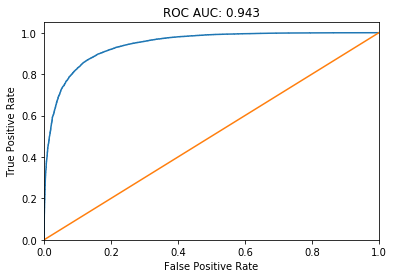

In [36]:
plot_roc_curve(basic_proba[:,1], y_class_test)

### Базовая модель даёт неплохой результат. Посмотрим, можно ли его улучшить.

In [37]:
svm_classifier = SGDClassifier(loss='hinge', penalty='l1',
                               max_iter=1000, early_stopping=True, n_iter_no_change=10,
                               n_jobs=8)

In [38]:
svm_classifier.fit(X_vector_train, y_class_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=True, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=10, n_jobs=8, penalty='l1',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [39]:
svm_classifier.n_iter_

11

In [40]:
svm_prediction = svm_classifier.predict(X_vector_test)

In [41]:
quality_report(svm_prediction, y_class_test)

Accuracy: 0.865
Precision: 0.870
Recall: 0.861
f1_score: 0.865


### SVM с линейным ядром даёт результаты, идентичные результатам базовой модели...

In [42]:
def visualize_coefficients(coef, feature_names, title, plot_num, color, take_top=True, n_features=25):
    if True==take_top:
        # take n greatest values
        interesting_coefficients = np.argsort(coef)[-n_features:]
    else:
        # take n lowest values
        interesting_coefficients = np.argsort(coef)[:n_features]
    
    plt.figure(figsize=(15, 10))
    plt.subplot(2, 1, plot_num + 1)
    colors = [color for c in coef[interesting_coefficients]]
    plt.bar(np.arange(n_features), coef[interesting_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(0, n_features), 
               feature_names[interesting_coefficients], rotation=60, ha="right", fontsize=14);
    plt.title(title)

### Набор 25-ти наиболее важных n-грамм для классификации отзыва.

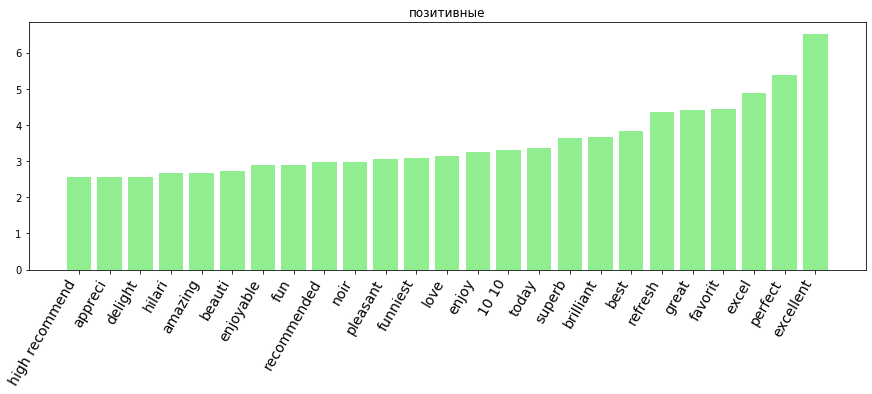

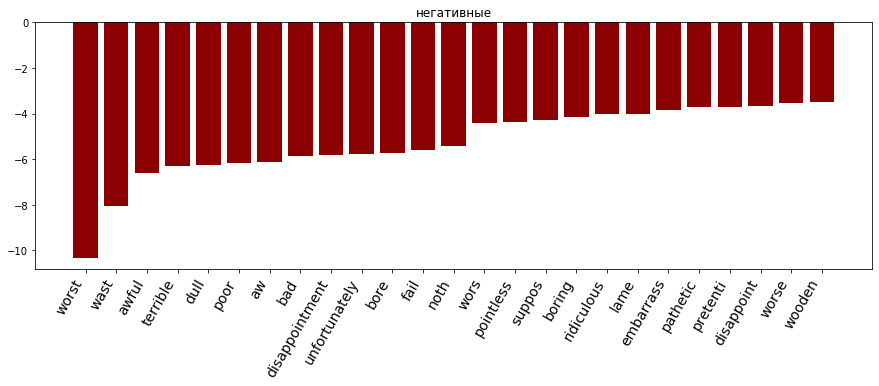

In [43]:
visualize_coefficients(svm_classifier.coef_[0,:], vectorizer.get_feature_names(),
                       title='позитивные', plot_num=0,
                       color = 'lightgreen', take_top=True)
visualize_coefficients(svm_classifier.coef_[0,:], vectorizer.get_feature_names(),
                       title='негативные', plot_num=1,
                       color = 'darkred', take_top=False)

In [44]:
top_pos_word_inices = np.argsort(svm_classifier.coef_[0,:])
vectorizer_dict = vectorizer.get_feature_names()
print(top_pos_word_inices[-4:])
print([vectorizer_dict[idx] for idx in top_pos_word_inices[-4:]])

[ 990  916 1984  917]
['favorit', 'excel', 'perfect', 'excellent']


In [45]:
print(top_pos_word_inices[:4])
print([vectorizer_dict[idx] for idx in top_pos_word_inices[:4]])

[3009 2937  227 2703]
['worst', 'wast', 'awful', 'terrible']


In [46]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

In [47]:
forest_classifier = RandomForestClassifier(n_estimators=1600, max_depth=64, n_jobs=8)

In [48]:
forest_classifier.fit(X_vector_train, y_class_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=64, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1600,
                       n_jobs=8, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [49]:
forest_prediction = forest_classifier.predict(X_vector_test)
forest_proba = forest_classifier.predict_proba(X_vector_test)

In [50]:
quality_report(forest_prediction, y_class_test)

Accuracy: 0.844
Precision: 0.850
Recall: 0.839
f1_score: 0.845


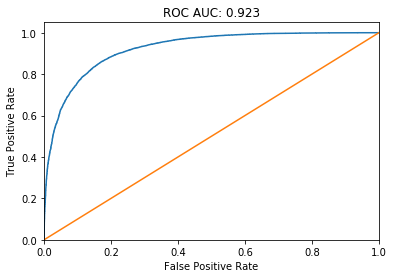

In [51]:
plot_roc_curve(forest_proba[:,1], y_class_test)

### Результаты Random Forest несколько хуже, чем у SVM и логистической регрессии.
### Смотрим наиболее и наименее важные n-граммы

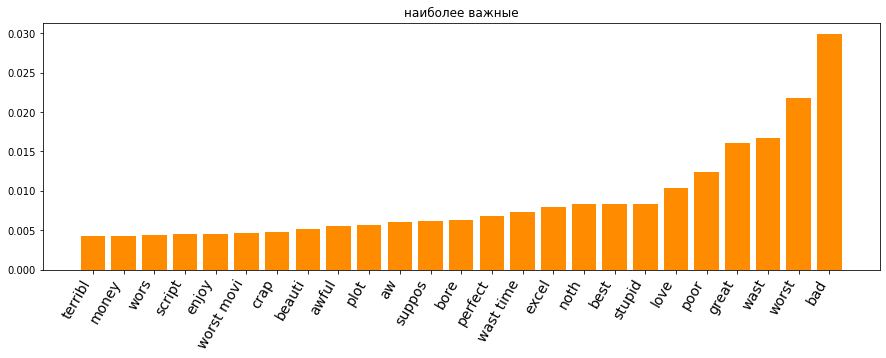

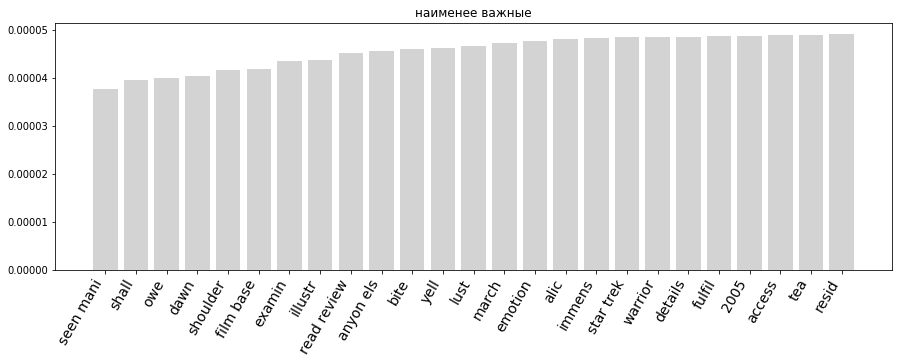

In [52]:
visualize_coefficients(forest_classifier.feature_importances_, vectorizer.get_feature_names(),
                       title='наиболее важные', plot_num=0,
                       color = 'darkorange', take_top=True)
visualize_coefficients(forest_classifier.feature_importances_, vectorizer.get_feature_names(),
                       title='наименее важные', plot_num=1,
                       color = 'lightgray', take_top=False)

## 4. Построение модели регрессии

In [53]:
from sklearn import metrics

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def print_metrics(y_true,y_pred):
    print('MAE:', metrics.mean_absolute_error(y_true, y_pred))
    print('RMSE:', np.sqrt(metrics.mean_squared_error(y_true, y_pred)))
    print('R2:',  metrics.r2_score(y_true, y_pred))
    print('MAPE:', mean_absolute_percentage_error(y_true, y_pred), '%')
    pass

In [54]:
def plot_regression_error(y_true,y_pred, title_text=''):
    true_min = np.min(y_true)
    true_max = np.max(y_true)
    plot_step = 0.1 * np.abs(true_min - true_max)
    pred_min = np.min(y_pred)
    pred_max = np.max(y_pred)
    
    range_min = min(true_min, pred_min)
    range_max = max(true_max, pred_max)
    f, ax = plt.subplots(1, 1);
    f.set_size_inches(10, 5)
    ax.scatter(y_true, y_pred)
    ax.plot(np.linspace(true_min, true_max, num=20), np.linspace(true_min, true_max, num=20), '-r')
    ax.set_ylabel('Target predicted')
    ax.set_xlabel('True Target')
    ax.set_title(title_text)
    ax.text(true_min, pred_max, r'$R^2$=%.2f, MAE=%.2f' % (
        metrics.r2_score(y_true, y_pred),
        metrics.median_absolute_error(y_true, y_pred))
    )
    ax.set_xlim([true_min - plot_step, true_max + plot_step])
    ax.set_ylim([range_min - plot_step, range_max + plot_step])

### В качестве базовой модели возьмём простую линейную регрессию

In [55]:
from sklearn.linear_model import LinearRegression

In [56]:
basic_regressor = LinearRegression(n_jobs=8)

In [57]:
basic_regressor.fit(X_vector_train, y_reg_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=8, normalize=False)

In [58]:
basic_score_estimation = basic_regressor.predict(X_vector_test)

In [59]:
print_metrics(y_reg_test, basic_score_estimation)

MAE: 1.8607781893056015
RMSE: 2.3105255595564174
R2: 0.561909823036566
MAPE: 72.37898434732695 %


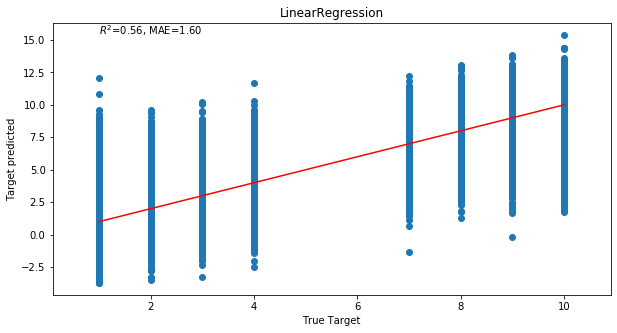

In [60]:
plot_regression_error(y_reg_test, basic_score_estimation, 'LinearRegression')

### Для простой линейной регрессии получили среднюю относительную ошибку 72% - это плохой результат

In [61]:
forest_regressor = RandomForestRegressor(n_estimators=400, max_depth=None, n_jobs=8, verbose=0)

In [62]:
forest_regressor.fit(X_vector_train, y_reg_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=8,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [63]:
forest_score_estimation = forest_regressor.predict(X_vector_test)

In [64]:
print_metrics(y_reg_test, forest_score_estimation)

MAE: 2.0097156016666666
RMSE: 2.5359840689763016
R2: 0.4722417839685956
MAPE: 77.65844816924603 %


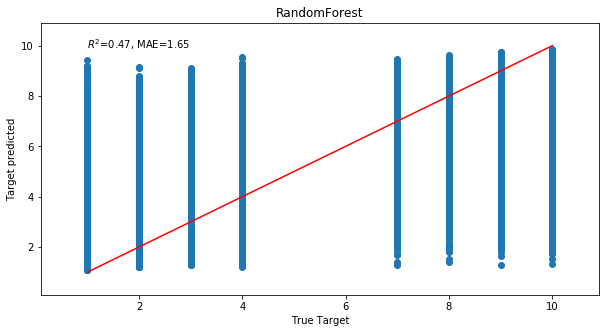

In [65]:
plot_regression_error(y_reg_test, forest_score_estimation, 'RandomForest')

### Для модели Random forest результат хуже, чем у базовой модели

In [66]:
from sklearn.neighbors import KNeighborsRegressor

In [67]:
knn_regressor = KNeighborsRegressor(n_neighbors=5, algorithm='auto')

In [68]:
knn_regressor.fit(X_vector_train, y_reg_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [69]:
knn_score_estimation = knn_regressor.predict(X_vector_test)

In [70]:
print_metrics(y_reg_test, knn_score_estimation)

MAE: 2.595416
RMSE: 3.178719490612533
R2: 0.17082467293710402
MAPE: 103.96017555555557 %


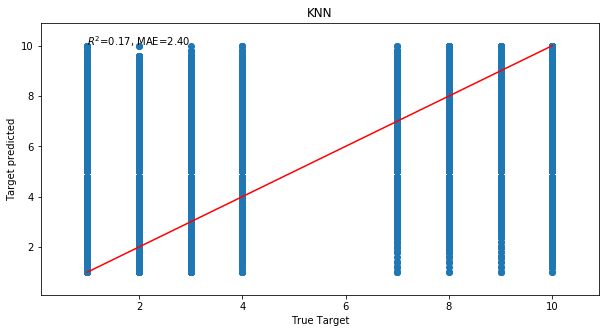

In [71]:
plot_regression_error(y_reg_test, knn_score_estimation, 'KNN')

In [72]:
from sklearn.linear_model import SGDRegressor

In [73]:
sgd_regressor = SGDRegressor(loss='squared_loss', early_stopping=True, n_iter_no_change=10)

In [74]:
sgd_regressor.fit(X_vector_train, y_reg_train)

SGDRegressor(alpha=0.0001, average=False, early_stopping=True, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=10, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [75]:
sgd_score_estimation = sgd_regressor.predict(X_vector_test)

In [76]:
print_metrics(y_reg_test, sgd_score_estimation)

MAE: 2.667390896431972
RMSE: 3.047833623903874
R2: 0.2377025396435819
MAPE: 99.48383729735309 %


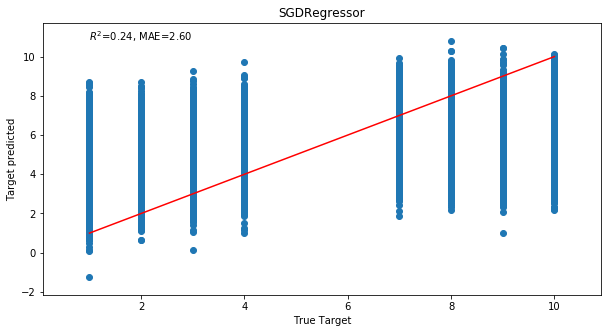

In [77]:
plot_regression_error(y_reg_test, sgd_score_estimation, 'SGDRegressor')

### Лучшие, хотя и неудовлетворительные, результаты показала базовая модель Linear regression.

## 5. Многоклассовая классификация вместо регрессии

### Целевая переменная - рейтинг фильма - целочисленная переменная, принимающая 8 различных значений: 1-4 для отрицаиельных отзывов и 7-10 для положительных.
### Задачу предсказания рейтинга можно рассматривать как задачу многоклассовой классификации.

In [78]:
from sklearn.metrics import classification_report, confusion_matrix

### В качестве базовой модели возьмём KNN классификатор с метрикой Jaccard.

In [79]:
from sklearn.neighbors import KNeighborsClassifier

In [80]:
from scipy.stats import norm, lognorm

In [81]:
knn_multi_classifier = KNeighborsClassifier(n_neighbors=10, n_jobs=8)

In [82]:
knn_multi_classifier.fit(X_vector_train, y_reg_test)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=8, n_neighbors=10, p=2,
                     weights='uniform')

In [83]:
knn_multi_predictions = knn_multi_classifier.predict(X_vector_test)
knn_multi_proba = knn_multi_classifier.predict_proba(X_vector_test)

### Метрики качества классификации:

In [84]:
print(accuracy_score(knn_multi_predictions, y_reg_test))
print(classification_report(knn_multi_predictions, y_reg_test))

0.22416
              precision    recall  f1-score   support

           1       0.52      0.29      0.37      9041
           2       0.06      0.10      0.07      1462
           3       0.08      0.12      0.10      1776
           4       0.07      0.12      0.09      1520
           7       0.09      0.12      0.10      1622
           8       0.13      0.16      0.14      2323
           9       0.07      0.13      0.09      1205
          10       0.35      0.29      0.31      6051

    accuracy                           0.22     25000
   macro avg       0.17      0.17      0.16     25000
weighted avg       0.31      0.22      0.25     25000



### Смотрим распределение вероятностей отнесения тестовых данных к классам.

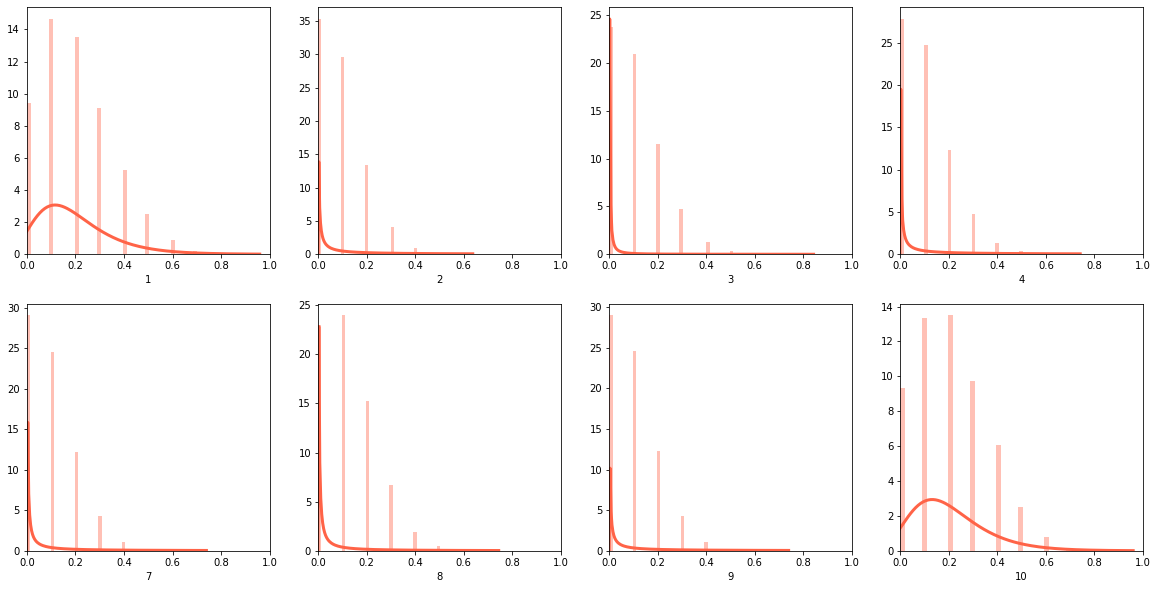

In [85]:
knn_multi_certainty = pd.DataFrame(data=knn_multi_proba, columns=['1','2','3','4','7','8','9','10'])
fig, axes = plt.subplots(nrows=2, ncols=4)
fig.set_size_inches(20, 10)
for idx, col in enumerate(knn_multi_certainty.columns):    
    row_idx = idx // 4
    col_idx = idx % 4
    ax=sns.distplot(knn_multi_certainty[col], kde=False, color='tomato',
                    fit=lognorm, fit_kws={'color':'tomato', 'lw':'3'},
                    norm_hist=False, ax=axes[row_idx, col_idx])
    ax.set_xlim([0,1])

### KNN классификатор лучше всего (точнее и увереннее) предсказывает только ДВА класса: наилучшие и наихудшие рейтинги.
### В целом, точность предсказания очень низкая.
### Возможно, эти отзывы имеют наиболее ярко выраженный набор выражений. К тому же, имеем соответствующий дисбаланс классов.

In [86]:
pd.Series(y_reg_test).value_counts()

1     5022
10    4999
8     2850
4     2635
3     2541
9     2344
7     2307
2     2302
Name: score, dtype: int64

In [87]:
sgd_multi_classifier = SGDClassifier(
    loss='log', penalty='l1',
    shuffle=True, early_stopping=True, n_iter_no_change=10, max_iter=1000
)

In [88]:
sgd_multi_classifier.fit(X_vector_train, y_reg_test)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=True, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=10, n_jobs=None, penalty='l1', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [89]:
sgd_multi_predictions = sgd_multi_classifier.predict(X_vector_test)
sgd_multi_proba = sgd_multi_classifier.predict_proba(X_vector_test)

In [90]:
print(accuracy_score(sgd_multi_predictions, y_reg_test))
print(classification_report(sgd_multi_predictions, y_reg_test))

0.35544
              precision    recall  f1-score   support

           1       0.87      0.38      0.53     11376
           2       0.00      0.09      0.00        35
           3       0.01      0.14      0.01       111
           4       0.01      0.14      0.01       102
           7       0.00      0.12      0.01        49
           8       0.00      0.08      0.00        90
           9       0.00      0.08      0.00        37
          10       0.90      0.34      0.49     13200

    accuracy                           0.36     25000
   macro avg       0.22      0.17      0.13     25000
weighted avg       0.87      0.36      0.50     25000



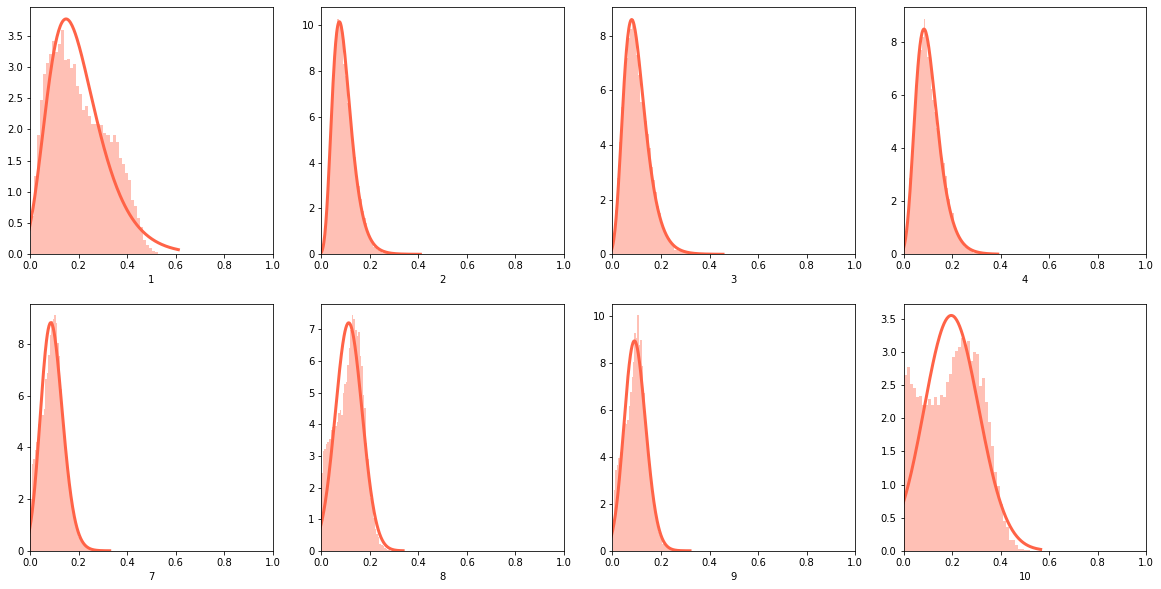

In [91]:
sgd_multi_certainty = pd.DataFrame(data=sgd_multi_proba, columns=['1','2','3','4','7','8','9','10'])
fig, axes = plt.subplots(nrows=2, ncols=4)
fig.set_size_inches(20, 10)
for idx, col in enumerate(sgd_multi_certainty.columns):    
    row_idx = idx // 4
    col_idx = idx % 4    
    ax=sns.distplot(sgd_multi_certainty[col], kde=False,
                    color='tomato',
                    fit=lognorm, fit_kws={'color':'tomato', 'lw':'3'},
                    norm_hist=False, ax=axes[row_idx, col_idx])
    ax.set_xlim([0,1])

### SGD классификатор с логистической регрессией также лучше всего (точнее и увереннее) предсказывает только ДВА класса: наилучшие и наихудшие рейтинги.

### Доля верных предсказаний для этих двух классов близка к доле верных предсказаний при бинарной классификации.

### Для остальных классов качество предсказания очень низкое!

In [92]:
def visualize_multi_coefficients(coef, feature_names, title, plot_num, n_top_features=10):
    interesting_coefficients = np.argsort(coef)[-n_top_features:]
    row_idx = plot_num // 4
    col_idx = plot_num % 4        
    ax=plt.subplot(2, 4, plot_num+1)
    colors = plt.get_cmap('RdYlGn')(np.linspace(0.7, 0.3, n_top_features))
    #colors = ['lightred' for c in coef[interesting_coefficients]]
        
    feature_names = np.array(feature_names)
    plt.barh(np.arange(n_top_features), coef[interesting_coefficients], color=colors)
    top_features = feature_names[interesting_coefficients]
    for y, word in enumerate(top_features):
        ax.text(0.3, y, word, ha='left', va='center', color='black', fontsize=18)   
    
    plt.yticks([]) 
    plt.title(title, fontsize=14)

### Смотрим наиболее важные для отнесения к класам n-граммы 

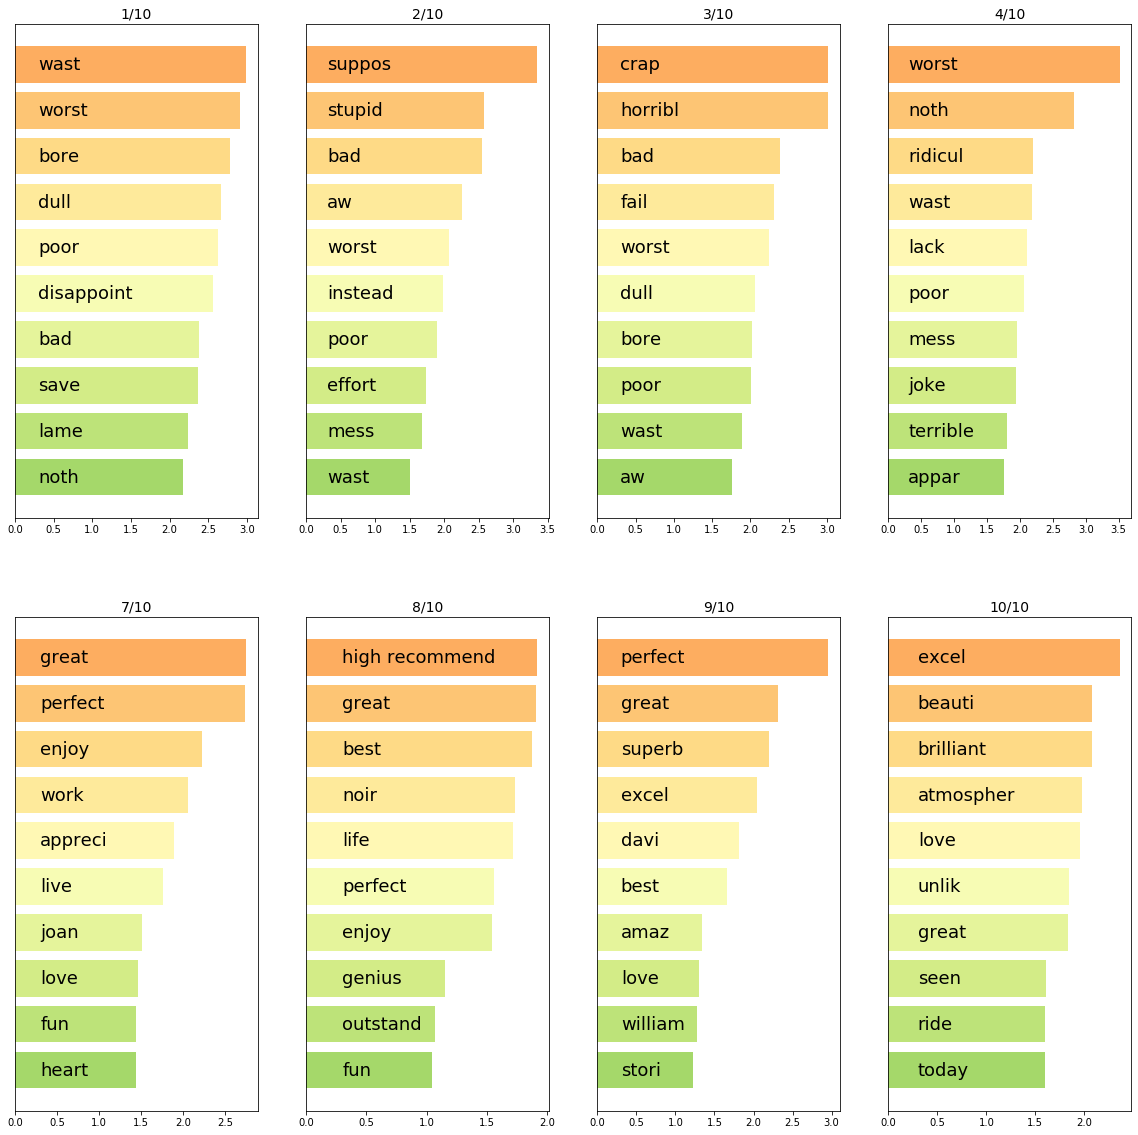

In [93]:
titles = ['1/10','2/10','3/10','4/10','7/10','8/10','9/10','10/10']
plt.figure(figsize=(20, 20))
for i in range(8):
    visualize_multi_coefficients(sgd_multi_classifier.coef_[i,:], vectorizer.get_feature_names(),
                      title=titles[i], plot_num=i)

### Видно, что группы классов 1-4 и 7-10 имеют много общих важных n-грамм.

## <font color=red>ОСНОВНОЙ ВЫВОД: ПОСТРОИТЬ УСПЕШНУЮ МОДЕЛЬ ПРЕДСКАЗАНИЯ РЕЙТИНГА НЕ УДАЛОСЬ.</font>
## <font color=red>ОДНАКО, ДОВОЛЬНО УСПЕШНО РАБОТАЕТ МОДЕЛЬ БИНАРНОЙ КЛАССИФИКАЦИИ ОТЗЫВОВ "ПОЗИТИВНЫЙ/НЕГАТИВНЫЙ".</font>
## СОБСТВЕННО, АВТОРЫ НАБОРА ДАННЫХ В ОПИСАНИИ И ХАРАКТЕРИЗУЮТ ЕГО КАК ПРЕДНАЗНАЧЕННЫЙ ДЛЯ БИНАРНОЙ КЛАССИФИКАЦИИ.